# UUZOP - PROJEKT - 2. FAZA - REPLIKACIJA REZULTATA

## Razrada članka
- Cilj je razumjevanje teme, postupka dobivanja rezultata i korištenih metodologija

#### SC - Skin Conductance
SC signal se sastoji od sporo promjenjive toničke komponente
na čijem vrhu se superponira brže promjenjiva fazna komponenta

#### Fazna komponenta
- Brzo promjenjiva
- Očitava se na vrhu toničke komponente
- Sastoji se od SCR-ova (skin conductance responses)
- Svaki od SCR-ova je generiran neuralnom aktivnosti
- Stope po kojima se javljaju SCR-ovi i njihove amplitude su markeri uzbuđenja

#### Tonička komponenta
- Sporo promjenjiva
- Povezana sa termoregulacijom
- Ovisi o temperaturi i vlažnosti okoline
- Zahvaća opće varijacije u uzbuđenju

#### Komponente SC signala
<img style="float: left;" src="Skin Conductance.png">

#### 1. korak - Niskopropusni filtar granične frekvencije (!?)
- Za izdvajanje SC trendova
- Visokopropusna filtrirana komponenta (s niskom graničnom frekvencijom) se oduzima od SC signala da bi se izdvojila tonička komponenta
- Oni koriste lowpass FIR filter - (primjer za python: https://scipy-cookbook.readthedocs.io/items/FIRFilter.html)

##### Odabir zasebnih graničnih frekvencija za filter (Budući da su razine buke različite za svaki signal)
<img style="float: left; display:block;" src="cutoff frequency.png" />
<br>

#### 2. korak - Izdvajanje značajki i klasifikacija
##### Vektor y 
- vektor svih uzoraka za svakog studenta za određeni ispit

#### Ekstrackija tri segmenta iz svakog trenda
- Uzimaju se segmenti sa početka, sredine i kraja testa (zbog pretpostavke oscilacija stresa tijekom vremena pisanja testa)
- Početni stres - osobni osjećaj sudionika da nije pripremljen
- Krajnji stres - zabrinutost u vezi s preostalim vremenom, umor, potreba za dovršavanjem ispita
- Tw - trajanje segmenta
- T - ukupno trajanje signala

<img style="float: left; display:block;" src="feature extraction.png" />
<br>
- Što se tiće značajki, unutar svakog prozora se izračunava srednja vrijednost i varijanca SC linije trenda

##### Matematički

###### Računjanje segmenata sa Tw:
- $y_{i:j}$ označava vektor koji se sastoji od uzoraka između i, j indeksa

<img style="float: left; display:block;" src="segmenti.png" />

##### Računanje srednje vrijednosti i varijance
- q € {start, mid, end}

<img style="float: left; display:block;" src="mean.png" />

##### Značajka omjera (ratio feature)
- Kako bi vidjeli kako su razine stresa rasle/padale tijekom sredine ispita u usporedbi sa početkom ili krajem ispita

<img style="float: left; display:block;" src="ratio.png" />

##### Difference signal
- informacija koliko se brzo/sporo povečavalo/smanjivalo uzbuđenje tijekom ispita

<img style="float: left; display:block;" src="ydiff.png" />

#### Finalni vektor značajki
$x = [ \mu_{start}, \mu_{mid}, \mu_{end}, \sigma^{2}_{start} \sigma^{2}_{mid}, \sigma^{2}_{end}, \rho, \mu_{diff}, \sigma^{2}_{diff}]$

#### Klasifikacija
- Značajke se uzimaju za $T_{w} = 5, 15, 30 min$
- Treniraju se zasebni klasifikatori za svaki $T_{w}$ te za svaki ispit
- Svakom vektoru značajki se dodaje oznaka visoke ili niske ocjene na temelju toga je li sudionik postigao rezultat >= 80%

- Koriste se klasifikatori iz aplikacije MATLAB 2017b sa defaultnim postavkama
- Procjena izvedbe klasifikatora se vrši sa 10-fold cross-validation

#### Rezultati

<img style="float: left; display:block;" src="rezultati1.png" />

## Postupak

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = os.getcwd()

### Definiranje statičnih varijabli koje će se koristiti kasnije
- Mapa sa bodovima
- Lista studenata
- Granične frekvencije za lowpass filter


In [3]:
students = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10']
grades = {
    "S01": {"midterm_1": 78, "midterm_2": 82, "final": 182},
    "S02": {"midterm_1": 82, "midterm_2": 85, "final": 180},
    "S03": {"midterm_1": 77, "midterm_2": 90, "final": 188},
    "S04": {"midterm_1": 75, "midterm_2": 77, "final": 149},
    "S05": {"midterm_1": 67, "midterm_2": 77, "final": 157},
    "S06": {"midterm_1": 71, "midterm_2": 64, "final": 175},
    "S07": {"midterm_1": 64, "midterm_2": 33, "final": 110},
    "S08": {"midterm_1": 92, "midterm_2": 88, "final": 184},
    "S09": {"midterm_1": 80, "midterm_2": 39, "final": 126},
    "S10": {"midterm_1": 89, "midterm_2": 64, "final": 116}
}

cutoff_frequencies_m1 = [0.002, 0.002, 0.0002, 0.002, 0.001, 0.002, 0.001, 0.0002, 0.002, 0.002]
cutoff_frequencies_m2 = [0.002, 0.001, 0.0002, 0.002, 0.001, 0.002, 0.0002, 0.002, 0.002, 0.002]
cutoff_frequencies_f = [0.002, 0.002, 0.001, 0.002, 0.001, 0.002, 0.0002, 0.002, 0.002, 0.002]

sample_rate = 4

### Funkcija za generiranje potrebnog vektora x sa 9 značajki
- prvi parametar funkcije predstavlja grupu tablica studenata za jedan određeni ispit
- Tw predstavlja vremenski raspon prozora očitavanja - ako je prozor očitavanja 15 minuta znači da su se samo unutar tih 15 minuta gledala mjerenja
- Na temelju Tw duljine prozora se kreiraju tri segmenta na temelju kojih se kreiraju njihove pripadajuće značajke
- U slučaju ovog članka imamo tri segmenta, koji se uzimaju na početku, sredini i kraju mjerenja, tj. na početku, sredini i kraju pisanja ispita
- Ta tri segmenta su važna budući da su u njima najzanimljivija moguča očitanja stresa - na primjer na početku ispita je stres moguć zbog pogleda na nerazumljiva pitanja, tijekom sredine ispita se razina stresa može spuštati, dok na kraju ispita može dosta rasti zbog ograničenog vremena pisanja i nedovršenosti ispita
- Nakon izračunavanja svih 9 značajki, one se pohranjuju u vektor x, koji će se koristiti u klasifikaciji

In [43]:
def get_final_vector(data, Tw, T, sample_rate):
    mod_Tw = Tw*60*sample_rate
    mod_T = T*60*sample_rate
    Ystart = data[0:mod_Tw]
    Ymid = data[int(mod_T/2) - int(mod_Tw/2) : int(mod_T/2) + int(mod_Tw/2)]
    Yend = data [mod_T - mod_Tw : mod_T]

    mi_start = np.mean(Ystart)
    mi_mid = np.mean(Ymid)
    mi_end = np.mean(Yend)
    
    si_start = np.var(Ystart)
    si_mid = np.var(Ymid)
    si_end = np.var(Yend)
    
    ro = mi_mid / (mi_start + mi_end)
    
    diff = np.array(Yend) - np.array(Ystart)
    mi_diff = np.mean(diff)
    si_diff = np.var(diff)
    
    x = [mi_start, mi_mid, mi_end, si_start, si_mid, si_end, ro, mi_diff, si_diff]
    
    return x

### Funkcija sa filtraciju skin conductance signala
- Ima svrhu izdvajanja toničke komponente radi ostvarenja preciznijih rezultata, eliminacijom visoko-frekventne fazne komponente
- Za svakog studenta i svaki test je odabrana granična frekvencija za filter, budući da su mjerenja za svaki slučaj drugačija, te je potrebna drugačija granica za izbjegavanje visoko-frekventne buke u signalu

In [25]:
from scipy.signal import butter, filtfilt

def lowpass_butter_filter(data, cutoff, sampling_frequency, order=4):
    nyq = 0.5 * sampling_frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    
    return pd.DataFrame(y, columns=[data.columns[0]])

### Funkcija za dodavanje značajke vezane uz ostvareni broj bodova
- Kriterij je osvajanje manje ili više od 80% bodova

In [26]:
def grade_labeling(grades_dict, test):
    y = []
    if test == 'final':
        edge = 160
    else:
        edge = 80
    for student in grades_dict:
        if(grades_dict[student][test] >= 80):
            y.append(1)
        else:
            y.append(0)
    return pd.DataFrame(y)

### Funkcija za klasifikaciju koja koristi k-Nearest Neighbors metodu u kombinaciji sa 10-fold cross-validation evaluacijom 

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

def KNN(data, y):
    kf = KFold(n_splits=10)
    score = []
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        x_train = data.loc[train_index]
        x_test = data.loc[test_index]
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]
        
        neigh = KNeighborsClassifier(n_neighbors=3).fit(np.array(x_train), np.array(y_train))
        score.append(neigh.score(x_test, y_test))
    return score, (score.count(1.0)/len(score))*100

### Priprema podataka
- Promatranjem očitavanja akcolometra vidljivo je da nisu krenuli mjeriti od početka pisanja ispita nego malo prije, tako da je prvi korak filtriranje EDA očitavanja na temelju vremena kada su očitana (na temelju akcolometra po Y osi)

In [44]:
def get_accY_dfs(test, dfs=[]):
    all_accY = []
    if len(dfs) == 0:
        for student in students:
            accY = pd.read_csv(path+'\\Data\\'+student+'\\'+test+'\\ACC.csv')
            accY = accY[accY.columns[1]]
            accY = accY.iloc[1:]
            all_accY.append(accY)
    else:
        all_accY = dfs
    return all_accY

In [45]:
def plot_accY(test, dfs=[], lim=50000):
    sample_rate = 32
    all_accY = get_accY_dfs(test, dfs)
    
    for i in range(len(all_accY)):
        plt.figure(figsize=(18, 5))
        plt.xlim(0, lim)
        plt.title("S"+str(i+1)+" - "+test)
        plt.plot(all_accY[i])

In [46]:
def cut_accY(test, cuts):
    all_accY = get_accY_dfs(test)
    
    all_accY[0] = all_accY[0].iloc[cuts[0]:]
    all_accY[1] = all_accY[1].iloc[cuts[1]:]
    all_accY[2] = all_accY[2].iloc[cuts[2]:]
    all_accY[3] = all_accY[3].iloc[cuts[3]:]
    all_accY[4] = all_accY[4].iloc[cuts[4]:]
    all_accY[5] = all_accY[5].iloc[cuts[5]:]
    all_accY[6] = all_accY[6].iloc[cuts[6]:]
    all_accY[7] = all_accY[7].iloc[cuts[7]:]
    all_accY[8] = all_accY[8].iloc[cuts[8]:]
    all_accY[9] = all_accY[9].iloc[cuts[9]:]
    
    return all_accY

In [47]:
def get_test_eda_dfs(test):
    eda_dfs = []
    for student in students:
        eda = pd.read_csv(path+'\\Data\\'+student+'\\'+test+'\\EDA.csv')
        eda = eda.iloc[1:]
        eda_dfs.append(eda)
    return eda_dfs

In [48]:
def cut_eda(eda_df, accY_cut):
    accY_sample_rate = 32
    eda_sample_rate = 4

    time_accY = accY_cut / accY_sample_rate
    eda_samples_to_remove = math.floor(time_accY * eda_sample_rate)
    
    return eda_df.iloc[eda_samples_to_remove:]

### Prikaz očitavanja akcolometra po Y osi, zumirano na prvih 50000 očitavanja
- Jasno je vidljivo da za primjer međuispita 1 prava očitavanja kreću tek od 45000. mjerenja pa nadalje
- Na temelju tog broja mjerenja i frekvencije očitavanja se računa vrijeme prije pravih mjerenja
- To vrijeme se iz akcolometarskih očitavanja prebacuje u EDA očitavavanje, gdje se množenjem sa frekvencijom očitavanja od EDA mjerenja dobiva broj mjerenja koja se moraju maknuti iz EDA očitanja

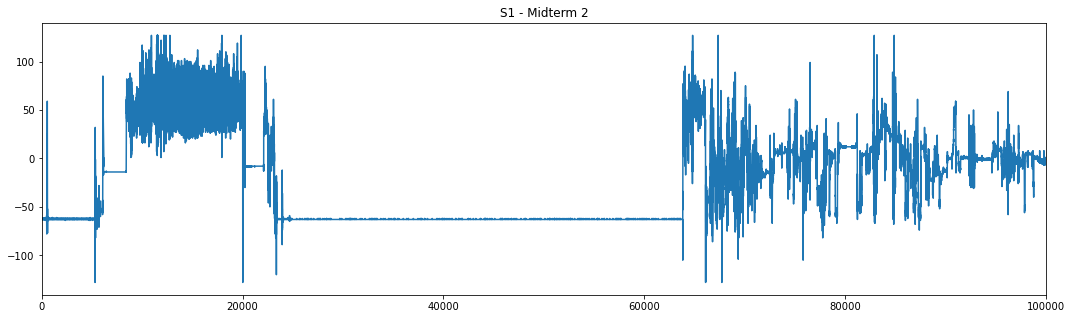

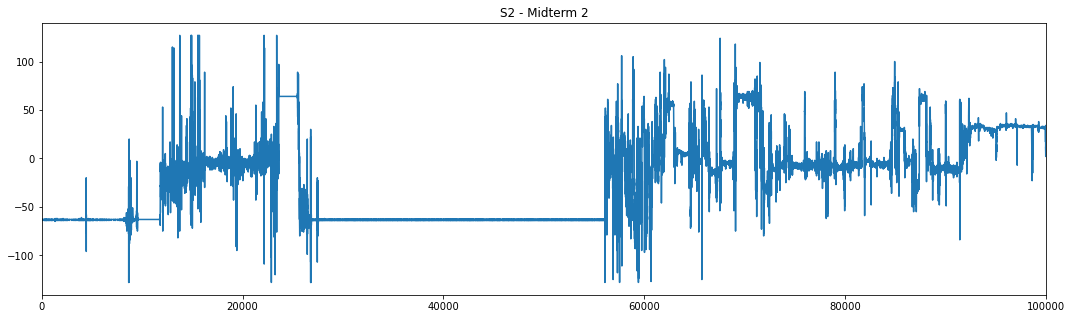

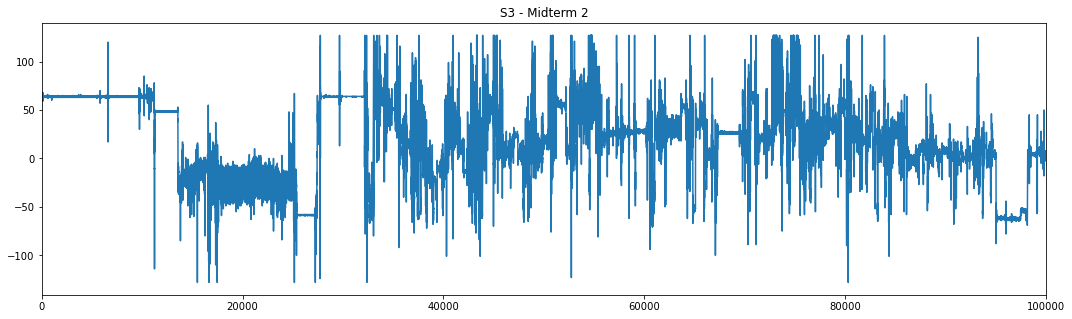

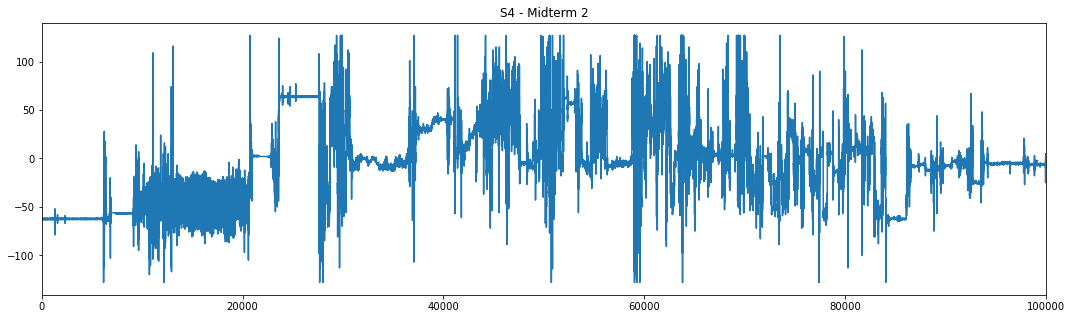

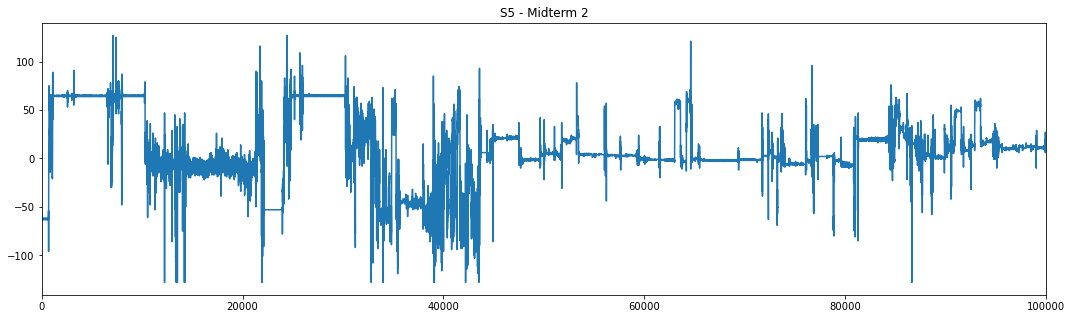

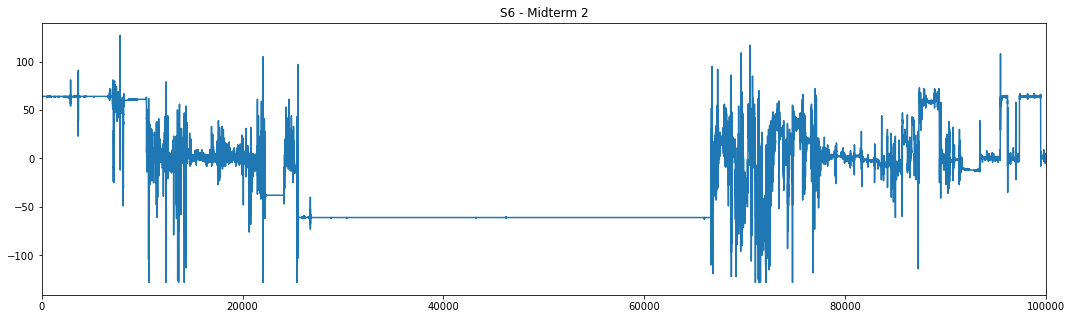

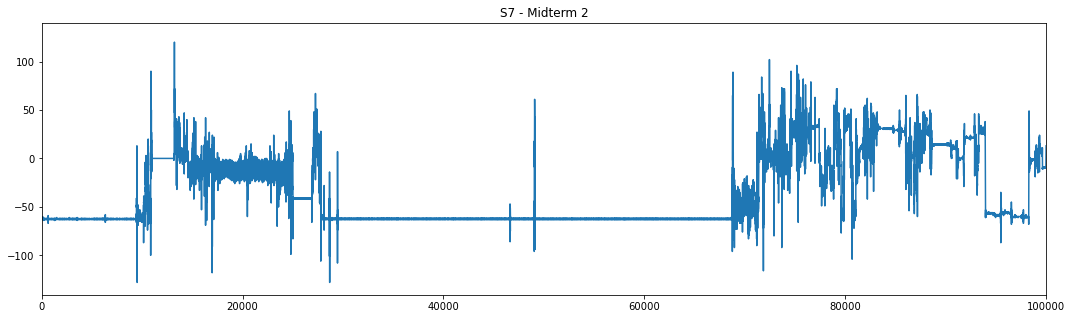

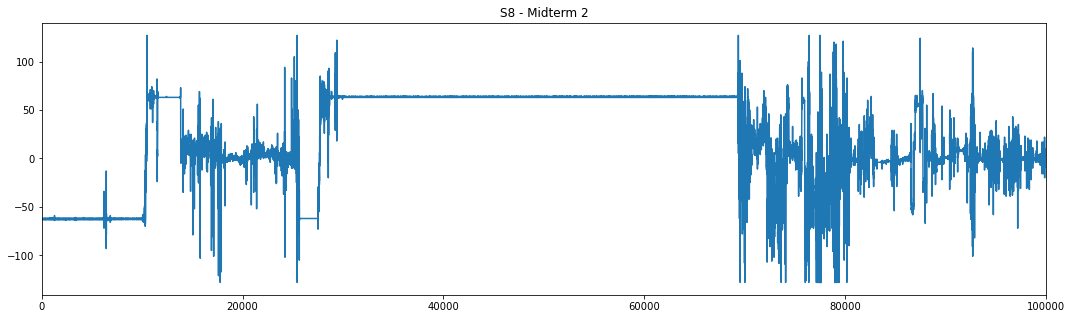

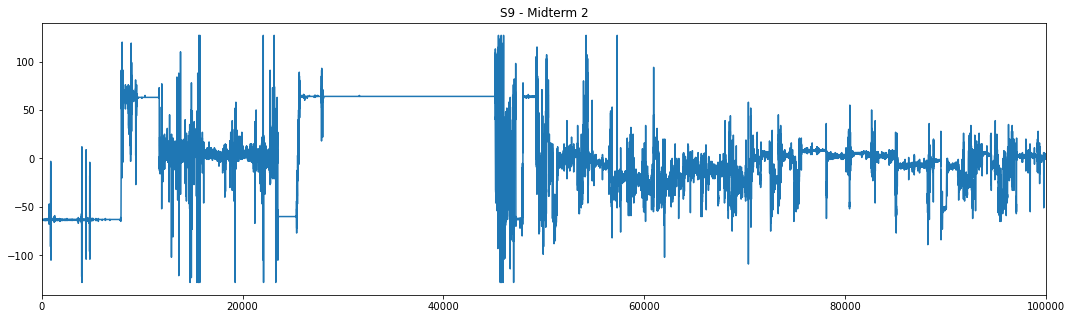

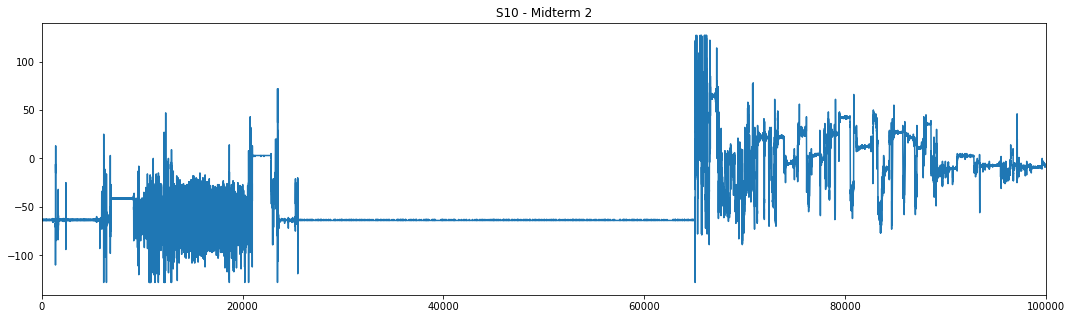

In [54]:
plot_accY('Midterm 2',[], 100000)

In [35]:
accY_m1_cuts = [46000, 47000, 44000, 46000, 47500, 44000, 44000, 45000, 46000, 47000]
accY_m2_cuts = [0,0,0,0,0,0,0,0,0,0]
accY_f_cuts = [35800,36100,1250,24900,1280,44100,37100,24000,47800,48000]

#### Prikaz "skraćenog" signala mjerenja akcolometra po Y osi
- U usporedbi sa gornjim prikazom, jasno je vidljivo da će se uzimati vremenski ispravna očitanja

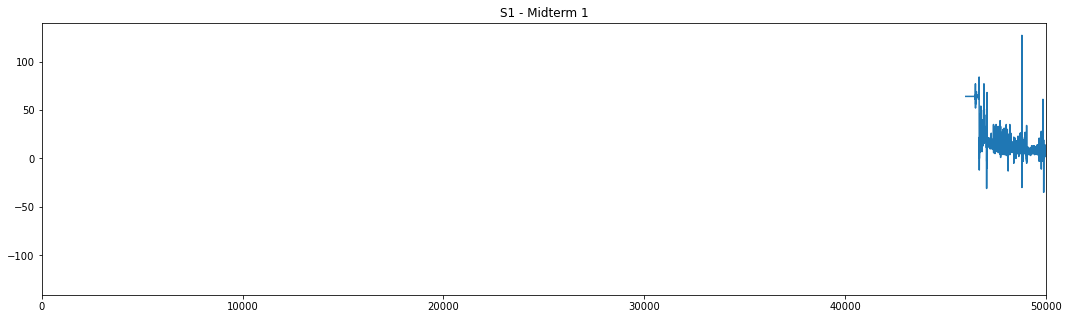

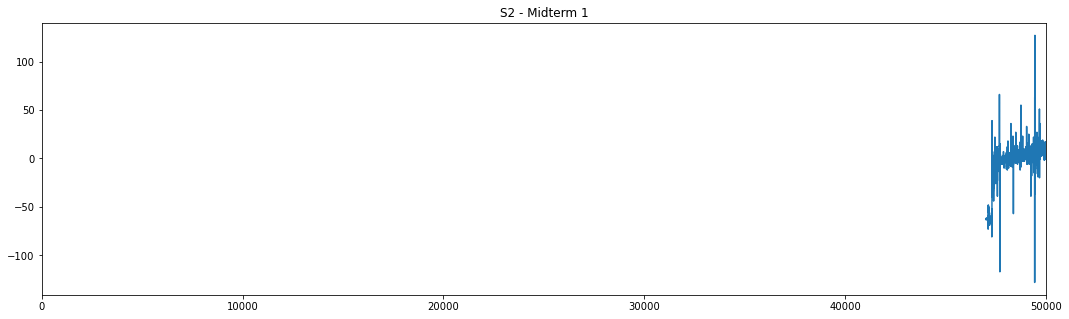

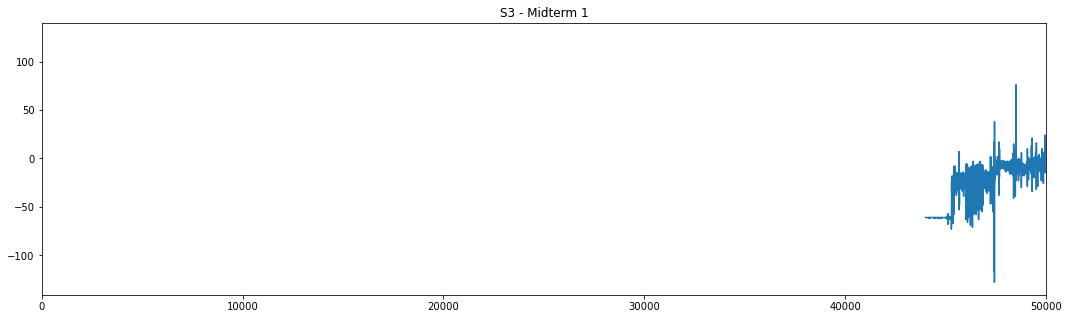

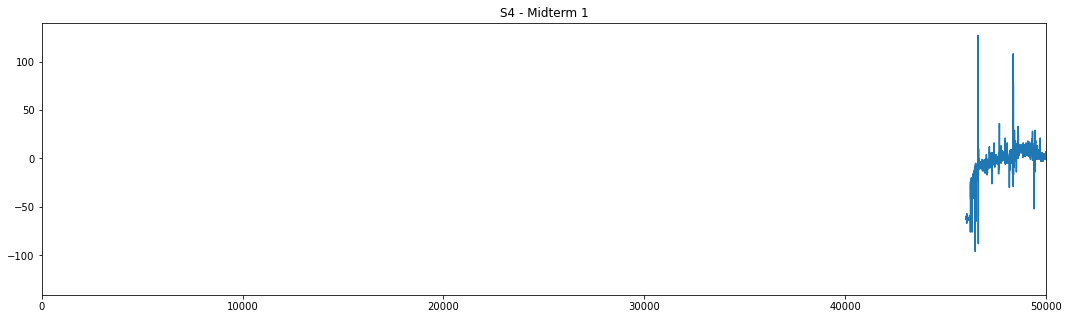

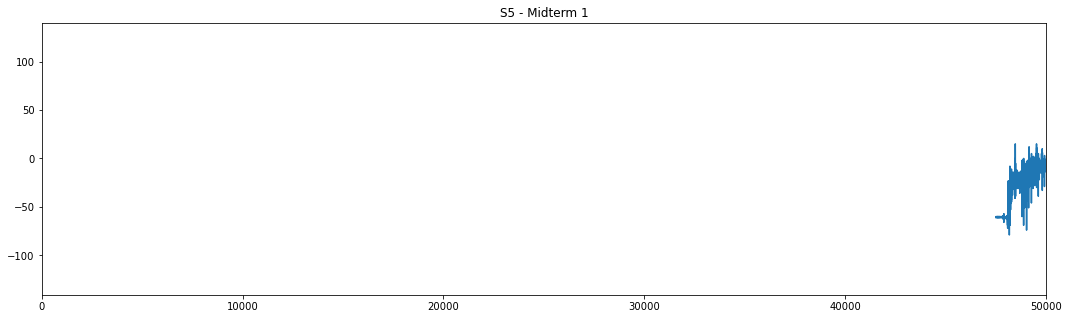

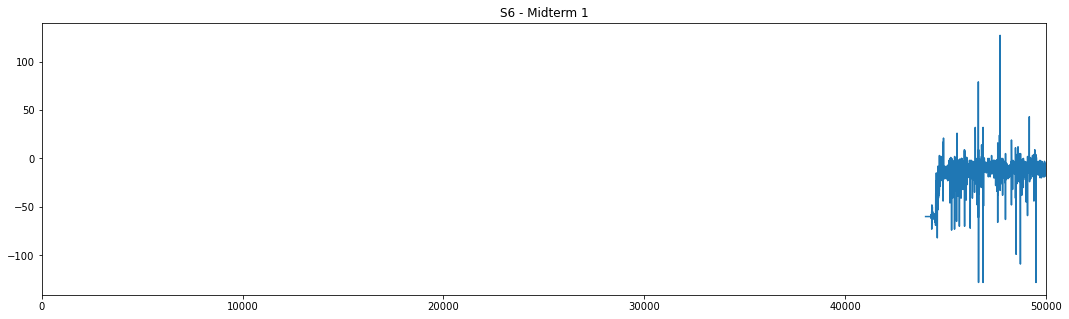

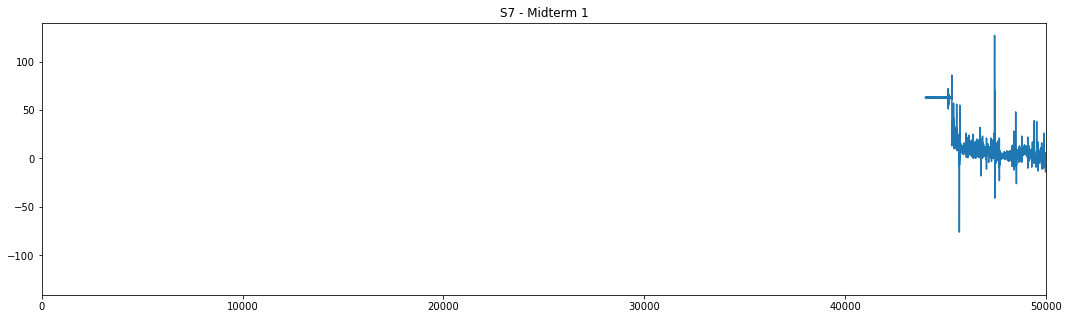

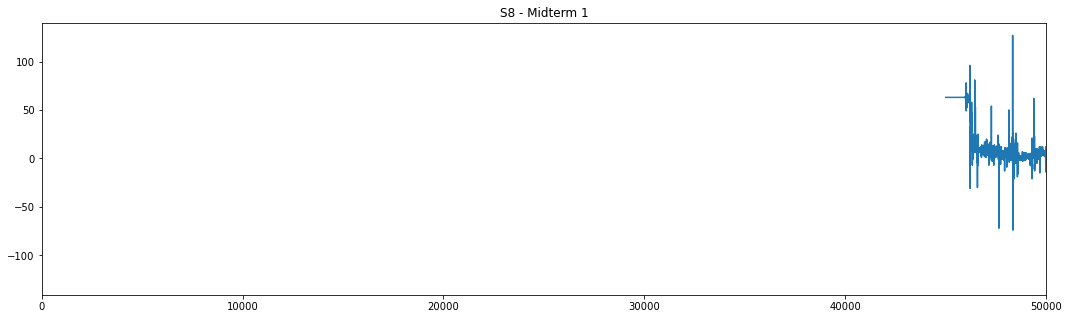

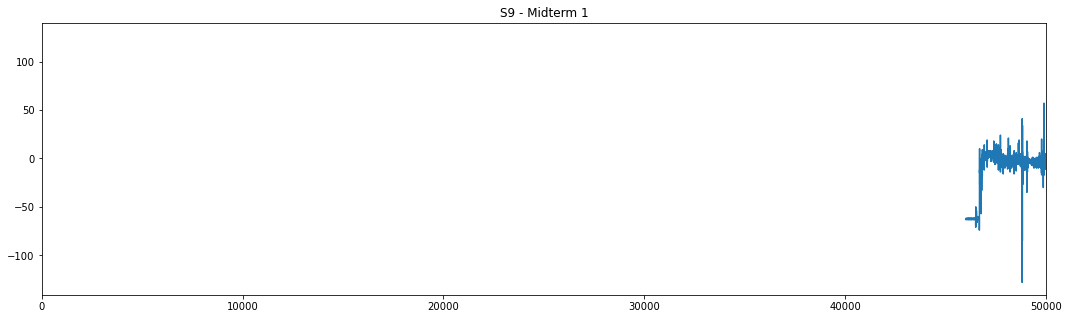

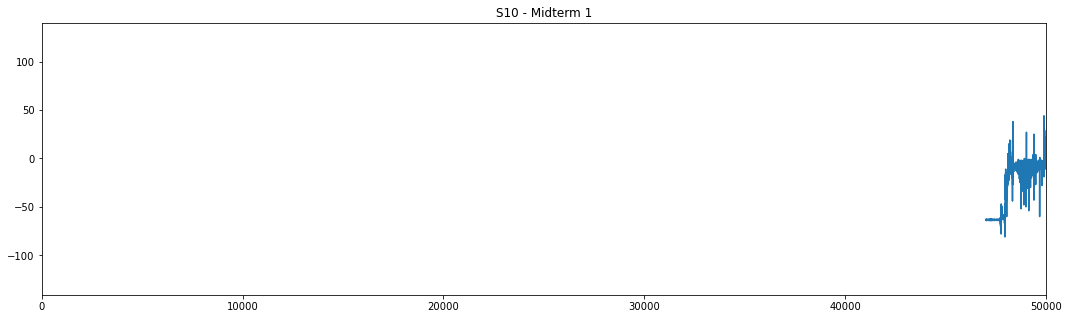

In [16]:
accs = cut_accY('Midterm 1', accY_m1_cuts)
plot_accY('Midterm 1', accs)

## Glavna funkcija za dobivanje vektora značajki x i y
Postupak je sljedeći:
1. Uzimaju se grupirana EDA očitavanja studenata za određeni ispit
2. Filtriranje EDA očitavanja na temelju akcolometra radi veće točnosti rezultata
3. Filtriranje EDA očitavanja sa lowpass FIR filterom i definiranim graničnim frekvencijama u svrhu izbacivanja komponente koja smanjuje točnost rezultata
4. Filtriranje EDA očitavanja je gotovo, te se na temelju njih kreira vektor koji se sastoji od 9 značajki
5. Kreira se značajka y na temelju ostvarenih bodova
6. Funkcija vraća vektore x i y, koji dalje idu u klasifikaciju

In [49]:
def get_xy(eda_set, accY_cuts, freq_cutoffs, Tw, T, test):
    x_labels = []
    for i in range(len(eda_set)):
        eda_set[i] = cut_eda(eda_set[i], accY_cuts[i])
        eda_set[i] = lowpass_butter_filter(eda_set[i], freq_cutoffs[i], 4, order=4)
        x = get_final_vector(eda_set[i].values.flatten(), Tw, T, 4)
        x_labels.append(x)

    y_labels = grade_labeling(grades, test)
    
    return x_labels, y_labels

### Klasifikacija i rezultati
- Ispisani su svi rezultati za sva tri ispita - Midterm 1, Midterm 2 i Final Exam, sa pripadajućim vremenskim okvirima mjerenja, koji iznose Tw = 5, 15 i 20 minuta

In [50]:
x,y = get_xy(get_test_eda_dfs('Midterm 1'), accY_m1_cuts, cutoff_frequencies_m1, 5, 90, 'midterm_1')
res, prec = KNN(pd.DataFrame(x),y)
print("Midterm 1 Test - 5 minutes window")
print("-"*40)
print("Accuracy: "+str(prec)+" %")
print("Result: "+str(res))
print()

x,y = get_xy(get_test_eda_dfs('Midterm 1'), accY_m1_cuts, cutoff_frequencies_m1, 15, 90, 'midterm_1')
res, prec = KNN(pd.DataFrame(x),y)
print("Midterm 1 Test - 15 minutes window")
print("-"*40)
print("Accuracy: "+str(prec)+" %")
print("Result: "+str(res))
print()

x,y = get_xy(get_test_eda_dfs('Midterm 1'), accY_m1_cuts, cutoff_frequencies_m1, 30, 90, 'midterm_1')
res, prec = KNN(pd.DataFrame(x),y)
print("Midterm 1 Test - 30 minutes window")
print("-"*40)
print("Accuracy: "+str(prec)+" %")
print("Result: "+str(res))
print()

x,y = get_xy(get_test_eda_dfs('Midterm 2'), accY_m2_cuts, cutoff_frequencies_m2, 5, 90, 'midterm_2')
res, prec = KNN(pd.DataFrame(x),y)
print("Midterm 2 Test - 5 minutes window")
print("-"*40)
print("Accuracy: "+str(prec)+" %")
print("Result: "+str(res))
print()

x,y = get_xy(get_test_eda_dfs('Midterm 2'), accY_m2_cuts, cutoff_frequencies_m2, 15, 90, 'midterm_2')
res, prec = KNN(pd.DataFrame(x),y)
print("Midterm 2 Test - 15 minutes window")
print("-"*40)
print("Accuracy: "+str(prec)+" %")
print("Result: "+str(res))
print()

x,y = get_xy(get_test_eda_dfs('Midterm 2'), accY_m2_cuts, cutoff_frequencies_m2, 30, 90, 'midterm_2')
res, prec = KNN(pd.DataFrame(x),y)
print("Midterm 2 Test - 30 minutes window")
print("-"*40)
print("Accuracy: "+str(prec)+" %")
print("Result: "+str(res))
print()

x,y = get_xy(get_test_eda_dfs('Final'), accY_f_cuts, cutoff_frequencies_f, 5, 180, 'final')
res, prec = KNN(pd.DataFrame(x),y)
print("Final Test - 5 minutes window")
print("-"*40)
print("Accuracy: "+str(prec)+" %")
print("Result: "+str(res))
print()

x,y = get_xy(get_test_eda_dfs('Final'), accY_f_cuts, cutoff_frequencies_f, 15, 180, 'final')
res, prec = KNN(pd.DataFrame(x),y)
print("Final Test - 15 minutes window")
print("-"*40)
print("Accuracy: "+str(prec)+" %")
print("Result: "+str(res))
print()

x,y = get_xy(get_test_eda_dfs('Final'), accY_f_cuts, cutoff_frequencies_f, 30, 180, 'final')
res, prec = KNN(pd.DataFrame(x),y)
print("Final Test - 30 minutes window")
print("-"*40)
print("Accuracy: "+str(prec)+" %")
print("Result: "+str(res))
print()

Midterm 1 Test - 5 minutes window
----------------------------------------
Accuracy: 80.0 %
Result: [1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]

Midterm 1 Test - 15 minutes window
----------------------------------------
Accuracy: 70.0 %
Result: [1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0]

Midterm 1 Test - 30 minutes window
----------------------------------------
Accuracy: 40.0 %
Result: [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]

Midterm 2 Test - 5 minutes window
----------------------------------------
Accuracy: 70.0 %
Result: [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]

Midterm 2 Test - 15 minutes window
----------------------------------------
Accuracy: 60.0 %
Result: [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]

Midterm 2 Test - 30 minutes window
----------------------------------------
Accuracy: 70.0 %
Result: [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]

Final Test - 5 minutes window
----------------------------------------
Accuracy: 100

### Osvrt na dobivene rezultate
Dobiveni rezultati odstupaju od rezultata postignutih u članku. Razlog toga su trenutno osobno neiskustvo s područjem (u odnosu na stručne autore članka), manjak točaka potvrde točnosti određenog koraka u replikaciji članka (na primjer potvrda i mogućnost usporedbe da je FIR filter ispravno implementiran, budući da se na njemu temelji sve dalje) kao i moguća odstupanja u filtriranju mjerenja na temelju akcelometra. Također, moguće je da postoje dodatne informacije koje su bile na korist autora članka, a koje nama nisu trenutno dostupne.
Također, kao osvrt na članak, rezultati bi možda bili bolji kada bi se uzimalo više okvira mjerenja a ne samo tri, na primjer da se uzme okvir od 10 minuta na razmacima od 5 minuta.

### Sljedeći korak
Budući da je sljedeći korak pokušaj poboljšavanja rezultata, plan je da se u obzir uzimaju i druga očitavanja sa Empatica E4 uređaja. Na raspolaganju su nam razna mjerenja koja su bila opisana u prošloj fazi projekta. Cilj je uzeti jedno od tih mjerenja koji je očitiji prikaz stresa, kao što su to na primjer mjerenja temperature i mjerenja broja otkucaja srca.